<a href="https://colab.research.google.com/github/mayowa-data/C7082/blob/main/Assessment_for_C7082.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

This assessment discusses the implementation of an image classification model for identifying different types of crops, The goal of using this technology is to improve the accuracy of crop identification systems on farms by farmers, researchers, and consumers in supermarkets. The model is based on convolutional neural networks (CNNs), which have multiple layers that can learn various features. CNNs are commonly used for image classification, object recognition, and speech recognition, and have achieved high levels of accuracy in these tasks.  Which forms the interest of this assessment. 

# Method

This section describes the methodology and the dataset used for this assessment. The convolutional neural network was used for this assessment as stated earlier. The Model was used in training a dataset of 770 images across thirty categories and achieved an accuracy of 99% training accuracy but the validation accuracy stalled at 25%. It was also used in training another fruit dataset with 297 images across two categories with 86% training accuracy and 71% validation accuracy. This assessment will focus on evaluating the effect of image size and class size on the training and validation accuracy of the training model.
o	The training and validation accuracy when the image size is set at 180X180, batch size = 32
o	The training and validation accuracy when the image size is set at 90X90, batch size = 32
o	While also comparing the outcome with testing the model on another dataset with 297 images and 2 classes (Apples and Tomatoes)


Import TensorFlow and other necessary libraries:

In [ ]:
# importing libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
import keras  
import os
import glob 
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from skimage import io 
from os import listdir
import random 
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

Importing and Loading data into dataframe from files in drive mounted on google collab

In [ ]:
crops_dir = '/content/drive/MyDrive/Agricultural-crops'
crops_dir = os.path.join(crops_dir)
crops_dir= glob.glob(crops_dir)



Define parameters for the loader

In [ ]:
batch_size = 32
img_height = 180
img_width =  180

Split the data for Training and Testing 60% for training and 40% for testing
It is important to split data.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Agricultural-crops',
validation_split=0.4,
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size= batch_size)

Found 770 files belonging to 30 classes.
Using 462 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Agricultural-crops',
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 770 files belonging to 30 classes.
Using 308 files for validation.


Print the class name for the dataset

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Cherry', 'Coffee-plant', 'Cucumber', 'Fox_nut(Makhana)', 'Lemon', 'Olive-tree', 'Pearl_millet(bajra)', 'Tobacco-plant', 'almond', 'banana', 'cardamom', 'chilli', 'clove', 'coconut', 'cotton', 'gram', 'jowar', 'jute', 'maize', 'mustard-oil', 'papaya', 'pineapple', 'rice', 'soyabean', 'sugarcane', 'sunflower', 'tea', 'tomato', 'vigna-radiati(Mung)', 'wheat']


Visualize the data

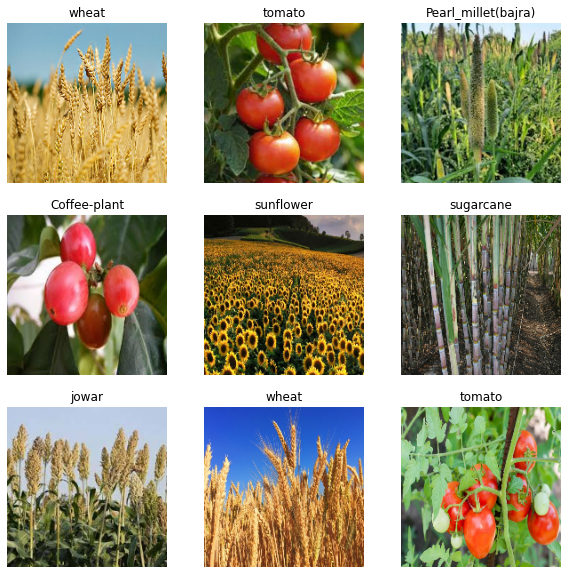

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Iterate over the dataset and retrieve batches of images

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Autotune your data to optimize performance d

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

Reduce the RGB channel values to between [0,1] to make it ideal for neural network

In [ ]:
normalization_layer = layers.Rescaling(1./255)

Apply normalization to the dataset by callinng Dataset.map

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Create the model
The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu').

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model
I am choosing the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model summary
View all the layers of the network using the Keras Model.summary method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Train the model
Train the model for 15 epochs with the Keras Model.fit method:

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
15/15 [==============================] - 116s 8s/step - loss: 3.6605 - accuracy: 0.0238 - val_loss: 3.3924 - val_accuracy: 0.0325
Epoch 2/15
15/15 [==============================] - 1s 34ms/step - loss: 3.3513 - accuracy: 0.0671 - val_loss: 3.3431 - val_accuracy: 0.0747
Epoch 3/15
15/15 [==============================] - 0s 29ms/step - loss: 3.1524 - accuracy: 0.1364 - val_loss: 3.3137 - val_accuracy: 0.0617
Epoch 4/15
15/15 [==============================] - 0s 29ms/step - loss: 2.7727 - accuracy: 0.2446 - val_loss: 3.0708 - val_accuracy: 0.1201
Epoch 5/15
15/15 [==============================] - 0s 29ms/step - loss: 2.2132 - accuracy: 0.3983 - val_loss: 3.1114 - val_accuracy: 0.1916
Epoch 6/15
15/15 [==============================] - 0s 29ms/step - loss: 1.7063 - accuracy: 0.5260 - val_loss: 3.1878 - val_accuracy: 0.2403
Epoch 7/15
15/15 [==============================] - 0s 30ms/step - loss: 1.1372 - accuracy: 0.7208 - val_loss: 3.4204 - val_accuracy: 0.2532
Epoch 8/15
15

Visualize training results

See the result of the training by creating plots of the loss and accuracy on the training and validation sets:

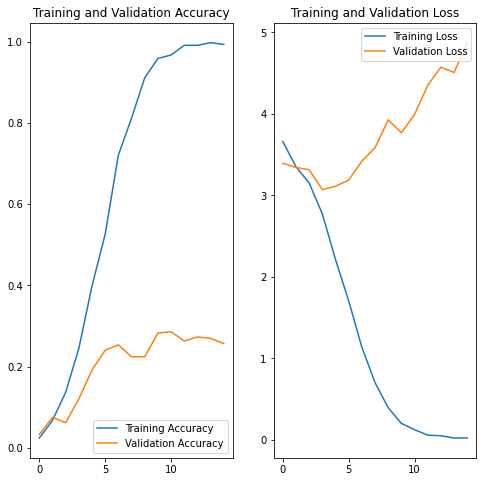

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 26% accuracy on the validation set. 
There is an overfitting in the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 26% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable.
 
Now we check what is wrong and try to improve the overall performance


Data Augumentation

Data Augumentation This helps with the overfitting problem by generating more training data from your existing dataset by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

we will activate data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times

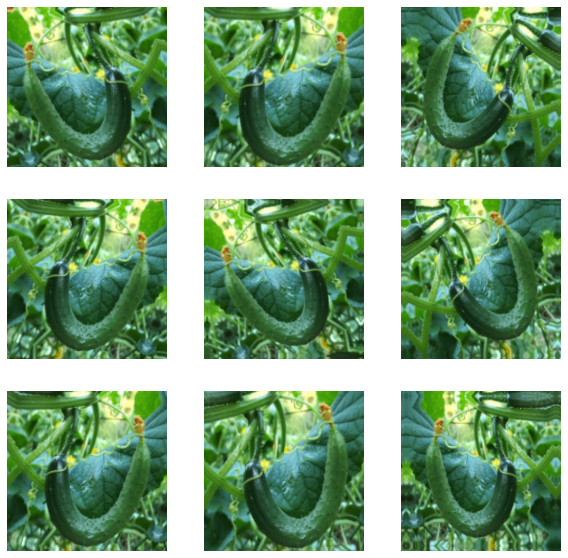

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout We can also reduce overfitting  by introducing Dropout to regularize the network.
When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with tf.keras.layers.Dropout before training it using the augmented images:

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
15/15 [==============================] - 2s 58ms/step - loss: 3.5207 - accuracy: 0.0455 - val_loss: 3.3787 - val_accuracy: 0.0552
Epoch 2/20
15/15 [==============================] - 1s 46ms/step - loss: 3.2842 - accuracy: 0.0714 - val_loss: 3.2580 - val_accuracy: 0.0779
Epoch 3/20
15/15 [==============================] - 1s 44ms/step - loss: 3.0523 - accuracy: 0.1277 - val_loss: 3.1284 - val_accuracy: 0.1169
Epoch 4/20
15/15 [==============================] - 1s 46ms/step - loss: 2.8687 - accuracy: 0.1602 - val_loss: 2.9874 - val_accuracy: 0.1558
Epoch 5/20
15/15 [==============================] - 1s 45ms/step - loss: 2.7487 - accuracy: 0.2100 - val_loss: 3.0657 - val_accuracy: 0.1234
Epoch 6/20
15/15 [==============================] - 1s 45ms/step - loss: 2.5980 - accuracy: 0.2727 - val_loss: 2.9355 - val_accuracy: 0.1883
Epoch 7/20
15/15 [==============================] - 1s 46ms/step - loss: 2.4825 - accuracy: 0.2835 - val_loss: 2.9299 - val_accuracy: 0.1948
Epoch 8/20
15

Visualize training results
After applying data augmentation and tf.keras.layers.Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned:

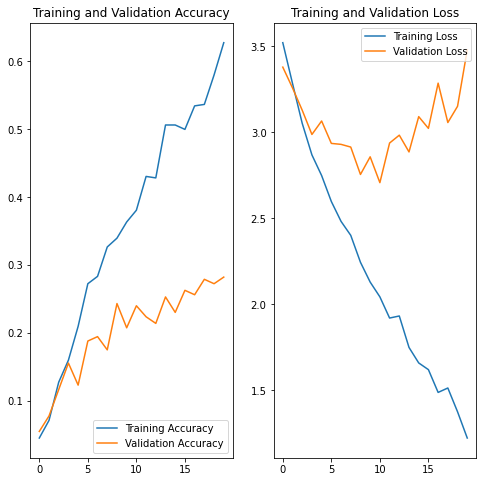

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Test your model on an image 

In [ ]:
pineaple_dir = '/content/drive/MyDrive/Agricultural-crops/pineapple/image (11).jpg'
pineaple_path = os.path.join('/content/drive/MyDrive/Agricultural-crops/pineapple')
from PIL import Image
img_data = np.random.random(size=(180, 180, 3))
img = tf.keras.preprocessing.image.array_to_img(img_data)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to pineapple with a 61.79 percent confidence.


Predict on new data

Use TensorFlow Lite
TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

Convert the Keras Sequential model to a TensorFlow Lite model
To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model.

Here, we will take the trained Keras Sequential model and use tf.lite.TFLiteConverter.from_keras_model to generate a TensorFlow Lite model:

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Run the TensorFlow Lite model
You can access the TensorFlow Lite saved model signatures in Python via the tf.lite.Interpreter class.

Load the model with the Interpreter:

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):

In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

Test the loaded TensorFlow Model by performing inference on a sample image with tf.lite.Interpreter.get_signature_runner by passing the signature name as follows:

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

We have already tensorized that image and saved it as img_array. Now, pass it to the first argument (the name of the 'inputs') of the loaded TensorFlow Lite model (predictions_lite), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to pineapple with a 61.79 percent confidence.


In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

9.536743e-06


# Discussion

Image size of (180 X180) and trained on 15 epochs
The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer ( tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense)  with 128 units on top of it that is activated by a ReLU activation function ('relu'). (tensflowlite) training a dataset image size is 90×90 and the total number of parameters is over 3 million, and batch size of 32 at 15 epochs. With this combination of training, we got a training accuracy of 99% and a validation accuracy of 25%. This suggests overfitting due to a large discrepancy between the training accuracy and the validation accuracy. The dataset was improved using data argumentation and dropout before retraining with 20 epochs to reduce the overfitting. The training accuracy dropped to 57% and the validation accuracy increased to 30%. The graph below shows the position of the dataset after augmentation.

I will be using this model on another image size which will be on a seprate notebook to avoid error. please see my github for the next.

However, this same model is still being deployed to tf_lifte model, but the overfitting is a massive draw back.


# Conclusion
The assessment on evaluating the effect of image size and class size on training and the validation accuracy of the training model shows that the model during training of the dataset with 30 classes struggles with overfitting which means the model cannot generalize and it’s fitting too closely to the training dataset and the varying of the image sizes from 180X180 to 90X90 and increased epochs could not correct the overfitting. The performance of the model in the other dataset however was the opposite despite its lower data sample. 
This assessment will therefore conclude that the performance of a model will generally be adversely affected when there is a higher number of classes of images in a dataset to be trained. However, the entire spectrum of Convolutional Neural Networks was not covered in this assessment.


My github repository link attached above has all the files containing my code and each experiment.


# Arranged in this order:

Assessment for C7082- ipnb For Experiment 1 (180X180)

Assessment for C7082- ipnb_2ipnb For experiment 2 (90X90)


C7082 Assessment - ipnb increased epochs Experiment 3 (Increased Epochs = 50)


Fruit_classification_ipnb – For experiment 4 Fruit dataset classification


# Reference 

Ahmed, M. Israk & Mamun, Shahriyar & Asif, Asif. (2021). DCNN-Based Vegetable Image Classification Using Transfer Learning: A Comparative Study. 235-243. 10.1109/ICCCSP52374.2021.9465499.


Tensorflowlite Creative Common Attribution 4.0 license and code samples are licensed under the  Apache 2.0 license.



Liang Yu1, Binbin Li1 and Bin Jiao1
Published under licence by IOP Publishing Ltd
IOP Conference Series: Material Science and Engineering, Volume 490, issue 4 
Citation Liang Yu et al 2019 IOP Conf. Ser.: Mater. Sci. Eng. 490 042022DOI 10.1088/1757-899X/490/4/042022
